# Procesamiento de Imagenes
## Integrantes

*   Martín Rodriguez Turco
*   Ian Díaz
*   Agustin Galdeman


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import matplotlib.pyplot as plt

mono_path = '/content/drive/Shareddrives/Imagenes/TP1 Grupo 1/Consigna/mono.bmp'
mono_image = plt.imread(mono_path)
# Helpers
def plot_image(image, title=None, display_size=False):
  if title:
    plt.title(title);
  plt.imshow(image, cmap='gray');
  if display_size:
    h, w = image.shape
    print("Width:", w)
    print("Height:", h)
  plt.show()

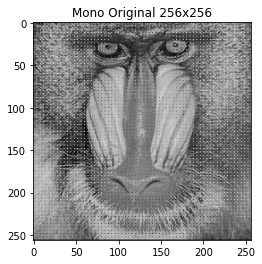

In [17]:
plot_image(mono_image, 'Mono Original 256x256');

## Dividir la imagen en parches de 4x4 y quedarnos con el pixel (1,1)
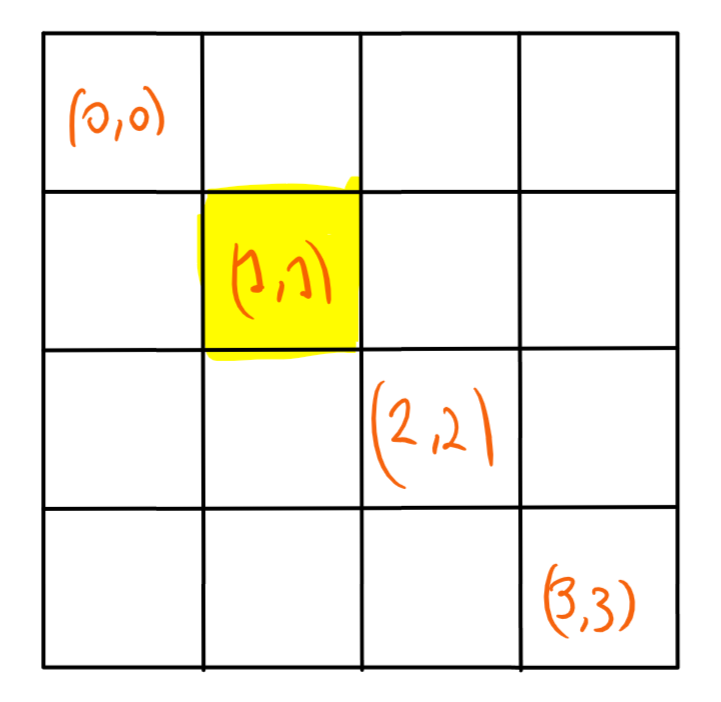

In [18]:
import numpy as np
def decimate_image(image, patch_size:tuple, x_offset, y_offset):
  image_copy = image.copy()
  patch_w, patch_h = patch_size
  image_width, image_height = image.shape
  num_blocks_x = image_width//patch_w
  num_blocks_y = image_height//patch_h

  x_coors = [x_offset+i*patch_w for i in range(num_blocks_x)]
  decimated_image = []
  for j in range(num_blocks_y):
    y_coors = [y_offset+j*patch_h for i in range(num_blocks_y)]
    decimate_row = image_copy[y_coors, x_coors]
    decimated_image.append(decimate_row)
  return np.array(decimated_image)

## Primera decimación tomando el pixel (1,1) de cada patch

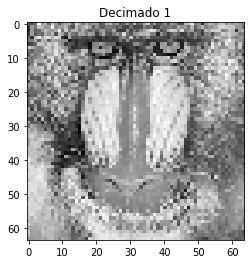

In [19]:
patch_size_1 = (4,4)
x_offset_1 = 1
y_offset_1 = 1
mono_decimated_1 = decimate_image(mono_image, patch_size_1, x_offset_1, y_offset_1)
plot_image(mono_decimated_1, title="Decimado 1")

## Ahora decimamos tomando el pixel en la posición (0,0). Es decir en la esquina superior izquierda

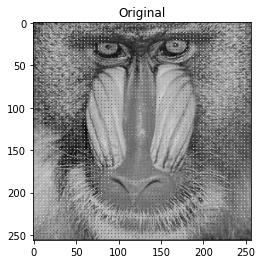

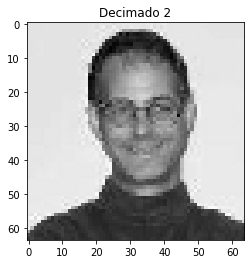

In [20]:
patch_size_2 = (4,4)
x_offset_2 = 0
y_offset_2 = 0
mono_decimated_2 = decimate_image(mono_image, patch_size_2, x_offset_2, y_offset_2)
plot_image(mono_image, title="Original")
plot_image(mono_decimated_2, title="Decimado 2")

aparecio Dani 😱🤯

## Decimación a partir del promedio. Es equivalente a hacer un AveragingPooling, el cual es en redes neuronales convolucionales

In [21]:
def view_as_blocks(image, patch_size:tuple):
  # Dividimos la imagen en blocks de tamaño patch_size
  patch_w, patch_h = patch_size
  image_height, image_width  = image.shape
  num_blocks_x = image_width//patch_w
  num_blocks_y = image_height//patch_h

  vertical_split = np.array(np.hsplit(image, num_blocks_x))
  horizontal_split = np.array(np.split(vertical_split, num_blocks_y, axis=1))
  image_as_blocks = horizontal_split 
  return image_as_blocks

def average_blocks(blocks):
  # Realizamos el promedio de cada bloque y guardamos una matriz de promedios
  avg_res = []
  for row in blocks:
    means_in_a_row = []
    for block in row:
      mean_res = block.mean()
      means_in_a_row.append(mean_res)
    avg_res.append(means_in_a_row)
  return avg_res 

def decimate_with_avg(image, patch_size:tuple):
  image_as_blocks = view_as_blocks(image, patch_size)
  averaged_image = average_blocks(image_as_blocks)
  return averaged_image

## Ejecutamos la decimación por promedio

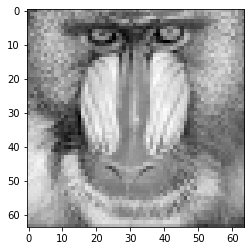

In [22]:
mono_avg = decimate_with_avg(mono_image, (4,4))
plot_image(mono_avg)

Podemos ver como aplicar el promedio a los bloques de 4x4 otorga un efecto de suavizado

## Implementación del algoritmo de interpolación bilineal
Para desarrollar el algoritmo de interpolación bilineal en una imagen, se realizar primero la interpolación unidimensional a lo largo de las filas de la imagen. Luego sobre la transpuesta de la misma, realizaremos nuevamente la interpolación lineal. Finalmente volvemos a rotarla para devolverla al estado original. 

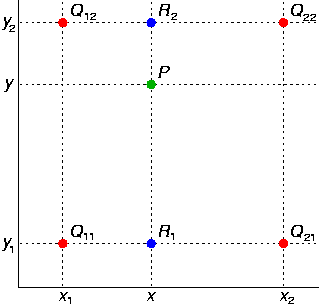


Dados los puntos en Rojo nos interesa realizar la interpolación sobre el punto P

### Interpolación 1D
La idea es ajustar una linea recta que pase entre dos puntos y poder calcular cualquier punto intermedio.
Sean $(x1,y1)$ y $(x2,y2)$ dos puntos en ${\rm I\!R}^2$ 
Tenemos que la linea que pasa a traves de esos dos puntos es

$$y(x) = \frac{x-x_2}{x_1-x_2} y_1 + \frac{x-x_1}{x_2-x_1} y_1$$ 

In [23]:
def interpolate(x, x1, y1, x2, y2):
  # Algoritmo de interpolación lineal unidimensional
  t1 = (x-x2)/(x1-x2)
  t2 = (x-x1)/(x2-x1)
  y_x = y1*t1 + y2*t2
  return y_x

In [24]:
def expand1d(arr, resize_factor):
  """Helper function que expande un array según el resize factor
  , dejando espacio libre para los valores que seran interpolados
  
  Example
  ------
  >>>arr = [1,2,3,4]
  >>>expand1d(arr, 4)
  [1., 0., 0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 4., 0., 0., 0.]
  """
  resized_arr = np.zeros(len(arr)*resize_factor)
  coors_from = np.arange(0, len(arr))
  coors_to = np.arange(0, len(resized_arr), resize_factor)
  for cf, ct in zip(coors_from, coors_to):
    resized_arr[ct] = arr[cf]
  return resized_arr

In [25]:
def interpolate_array(resized_array, resize_factor):
  """ Realizamos la interpolacion lineal sobre un array bidimensional pre-expandido
  """
  for counter, f_y in enumerate(resized_array):
    if counter % resize_factor == 0:
      x1 = np.maximum(counter-resize_factor, 0)
      y1 = resized_array[x1]  
      x2 = np.minimum(counter, len(resized_array)-1)
      y2 = resized_array[x2]

      for x in range(x1, x2):
        res = interpolate(x, x1, y1, x2, y2)
        resized_array[x] = res
  #Add padding
  resized_array[-3:] = resized_array[-4]
  return resized_array

In [26]:
def resize_bilinear(image, resize_factor):
  temp_image = [] 

  for row in image:
    expanded_row = expand1d(row, resize_factor)
    interpolated_row = interpolate_array(expanded_row, resize_factor)
    temp_image.append(interpolated_row)
  
  temp_image = np.array(temp_image).T
  new_image = []

  for row in temp_image:
    expanded_row = expand1d(row, resize_factor)
    interpolated_row = interpolate_array(expanded_row, resize_factor)
    new_image.append(interpolated_row)

  new_image = np.array(new_image).T
  return new_image

## Rescale de las imagenes | Uso de Bilineal

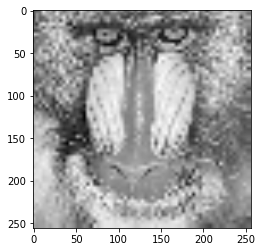

In [27]:
mono_decimated_1_resize = resize_bilinear(mono_decimated_1, 4)
plot_image(mono_decimated_1_resize)

Vemos que el shape se ajuste al original

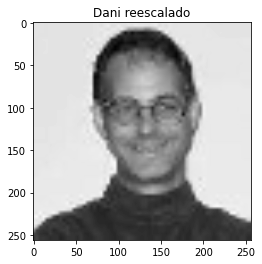

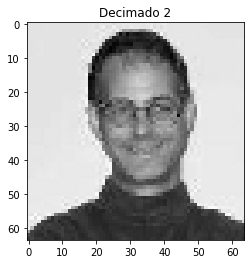

In [28]:
mono_decimated_2_resize = resize_bilinear(mono_decimated_2, 4)
plot_image(mono_decimated_2_resize, title="Dani reescalado")
plot_image(mono_decimated_2, title="Decimado 2")

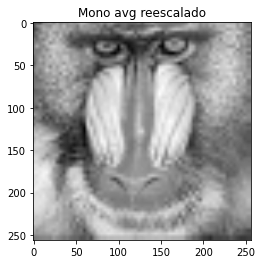

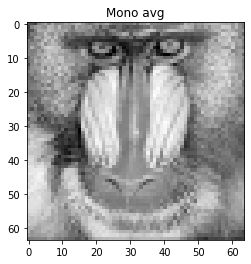

In [29]:
mono_avg_resize = resize_bilinear(mono_avg, 4)
plot_image(mono_avg_resize, title="Mono avg reescalado")
plot_image(mono_avg, title="Mono avg")

Vemos que el shape es nuevamente 256x256

In [30]:
mono_decimated_2_resize.shape

(256, 256)

# Bicubic resize
Seguimos un esquema similar al de la interpolación bilineal pero en este caso utilizamos 4 puntos consecutivos para realizar la interpolación en un sentido y luego realizamos la misma operación sobre la matriz transpuesta.
Para evitar artefactos se utilizo un overlap de 1 muestra.

In [31]:
from scipy.interpolate import interp1d

In [37]:
def interpolate_cubic(arr):
  # Ajustamos un polinomio de interpolación cubica
  cubic_pol = interp1d(np.arange(0, len(arr)), arr)
  return cubic_pol

def resize_bicubic(image, resize_factor):
  temp_image = [] 
  interpolation_range = np.linspace(0, 3, resize_factor*3+1)
  
  def interpolate1d_cubic(image, resize_factor):
    for row in image:
      new_row = []
      start = 0
      end = 4
      step = 3
      while end < len(row)+end:
        segment = row[start:end]
        if len(segment) != 4:
          break
        cubic_pol =  interpolate_cubic(segment)
        for x in interpolation_range:
          y = cubic_pol(x)
          new_row.append(y)
        start+=step
        end+=step
      temp_image.append(new_row)
    return np.array(temp_image)

  x_interpolate = interpolate1d_cubic(image, resize_factor)

  return x_interpolate

Sin overlap

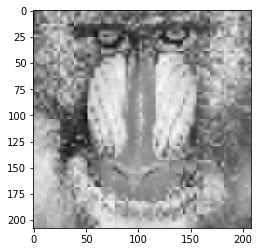

In [33]:
resize_1_temp = resize_bicubic(mono_decimated_1, 4)
resize_1 = resize_bicubic(resize_1_temp.T, 4).T
plot_image(resize_1)

Con overlap

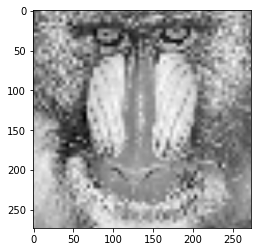

In [38]:
resize_1_temp = resize_bicubic(mono_decimated_1, 4)
resize_1 = resize_bicubic(resize_1_temp.T, 4).T
plot_image(resize_1)



---



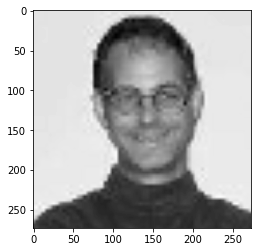

In [39]:
resize_2_temp = resize_bicubic(mono_decimated_2, 4)
resize_2 = resize_bicubic(resize_2_temp.T, 4).T
plot_image(resize_2)

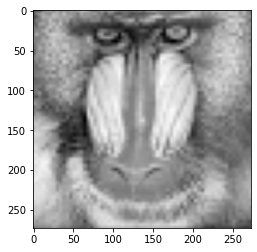

In [40]:
resize_3_temp = resize_bicubic(np.array(mono_avg), 4)
resize_3 = resize_bicubic(resize_3_temp.T, 4).T
plot_image(resize_3)

# FFT2

In [72]:
from scipy import fftpack
def plot_spectrum(im_fft):
  from matplotlib.colors import LogNorm
  # A logarithmic colormap
  plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
  plt.colorbar()

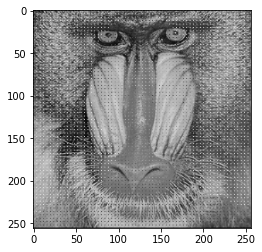

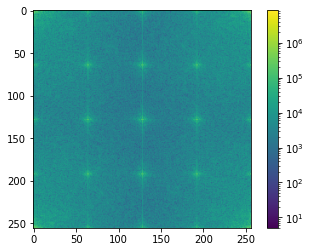

In [74]:
mono_1 = fftpack.fft2(mono_image)
plot_image(mono_image)
plot_spectrum(mono_1)

El centro de la imagen representa el componente de DC de la imagen. 
Por otro lado los puntos brillantes que estan arriba y abajo del punto central representan el tren periodico de puntitos la dirección horizontal. Del mismo modo los puntos brillantes horizontales corresponden a la repetición periodica en el sentido vertical. Las diagonalas, representan el tren puntos en las direcciones diagonales.

### Referencias
[Understanding Bilinear Image Resizing](https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html)

[Computerphile Bicubic interpolation](https://www.youtube.com/watch?v=poY_nGzEEWM)

[FFT2](http://www.unit.eu/cours/videocommunication/UNIT_Image%20Processing_nantes/Version%20US/Chapter%203/Exercises/FFT/Echap3_FFT_US%5Bfinal%5D.pdf)